In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('penajam_weather.csv')
df.head()

,Unnamed: 0,Date,Day,Temp,Wind,Weather
0,0,2015-01-01,1,26.6,53.2,Rain
1,1,2015-01-02,2,26.6,53.2,Rain
2,2,2015-01-03,3,26.6,53.2,Cloudy
3,3,2015-01-04,4,26.6,53.2,Rain
4,4,2015-01-05,5,26.6,53.2,Cloudy


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  722 non-null    int64  
 1   Date        722 non-null    object 
 2   Day         722 non-null    int64  
 3   Temp        722 non-null    float64
 4   Wind        722 non-null    float64
 5   Weather     722 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 34.0+ KB


In [4]:
df.describe()

,Unnamed: 0,Day,Temp,Wind
count,722.000000,722.000000,722.000000,722.000000
mean,360.500000,15.570637,26.780886,53.561773
std,208.567735,8.734399,0.577930,1.155860
min,0.000000,1.000000,26.000000,52.000000
25%,180.250000,8.000000,26.200000,52.400000
50%,360.500000,16.000000,26.700000,53.400000
75%,540.750000,23.000000,27.300000,54.600000
max,721.000000,31.000000,27.800000,55.600000


In [5]:
data = df[['Date', 'Temp']]
data = data.set_index('Date')

In [6]:
# minmax scaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_1 = scaler.fit_transform(data)

In [7]:
train_size = int(len(data_1)*0.8)
test_size = len(data_1) - train_size
X_data, y_data = data_1[0: train_size, :], data_1[train_size: len(data_1), :1]
train_size, test_size

(577, 145)

In [8]:
def dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [9]:
# split data
X_train, y_train = dataset(X_data, 100)
X_test, y_test = dataset(y_data, 100)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
threshold = (data['Temp'].max() - data['Temp'].min()) * 10/100
print(threshold)

0.18000000000000008


In [11]:
# create model
model = Sequential([
    LSTM(128, return_sequences = True, input_shape=(100, 1)),
    Dropout(0.1),
    LSTM(128, return_sequences = True),
    Dropout(0.1),
    Bidirectional(LSTM(16)),
    Dropout(0.1),
    Dense(4, activation = 'relu'),
    Dense(1)
])
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fa8c13c64a0>>

In [12]:
# callback
auto_stop_learn = EarlyStopping(
    monitor = 'loss',
    min_delta = 0,
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [13]:
# train model
optimizer = 'adam'
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 128,
    callbacks = auto_stop_learn,
    verbose = 1
)

Epoch 1/100
4/4 [==============================] - 22s 2s/step - loss: 0.1499 - mae: 0.4351 - val_loss: 0.2545 - val_mae: 0.7129
Epoch 2/100
4/4 [==============================] - 3s 783ms/step - loss: 0.1327 - mae: 0.4036 - val_loss: 0.1945 - val_mae: 0.6227
Epoch 3/100
4/4 [==============================] - 3s 778ms/step - loss: 0.0983 - mae: 0.3525 - val_loss: 0.1210 - val_mae: 0.4910
Epoch 4/100
4/4 [==============================] - 3s 852ms/step - loss: 0.0681 - mae: 0.3105 - val_loss: 0.0672 - val_mae: 0.3652
Epoch 5/100
4/4 [==============================] - 4s 970ms/step - loss: 0.0563 - mae: 0.2921 - val_loss: 0.0307 - val_mae: 0.2461
Epoch 6/100
4/4 [==============================] - 3s 761ms/step - loss: 0.0568 - mae: 0.3010 - val_loss: 0.0245 - val_mae: 0.2194
Epoch 7/100
4/4 [==============================] - 3s 746ms/step - loss: 0.0564 - mae: 0.3001 - val_loss: 0.0298 - val_mae: 0.2424
Epoch 7: early stopping


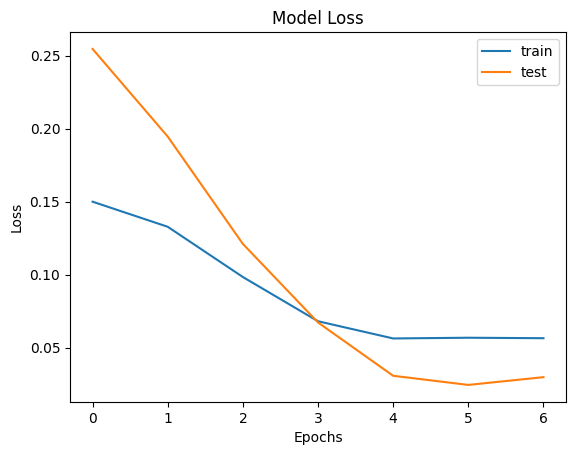

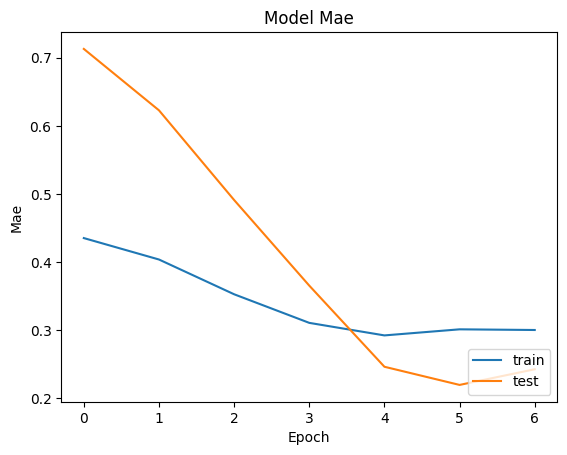

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [15]:
model.save("./temp_penajam.h5")

2/2 [==============================] - 3s 129ms/step


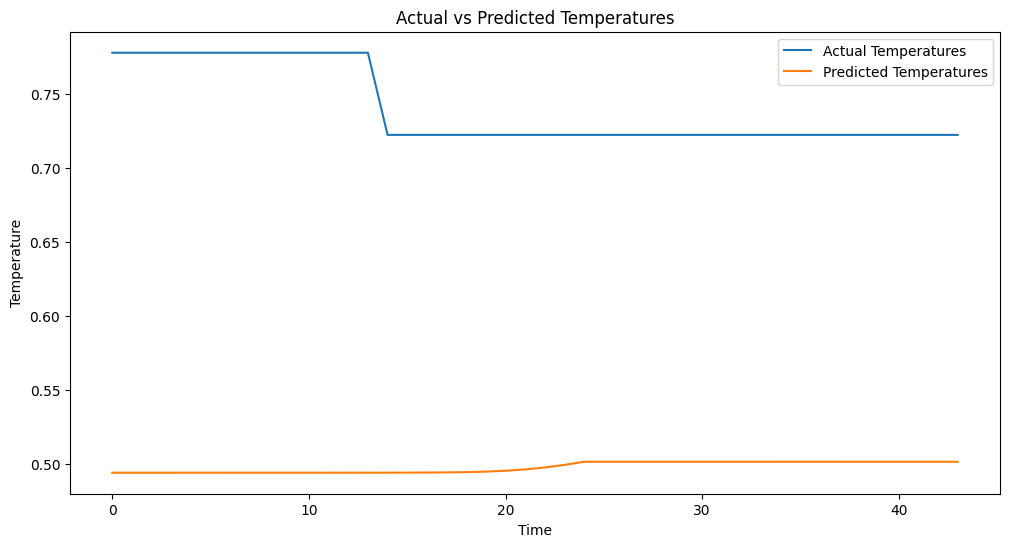

In [16]:
# Make predictions
predictions = model.predict(X_test)

# Create an array of dates corresponding to the test set
x_values = np.arange(len(y_test))

# Plot the predicted temperatures against the x-axis values
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_test, label='Actual Temperatures')
plt.plot(x_values, predictions, label='Predicted Temperatures')
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [17]:
import datetime
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("temp_penajam.h5")

def predict_temperature(year, month, day):
    # Tanggal yang akan diprediksi suhunya
    input_date = datetime.date(year, month, day)

    # Tentukan tanggal referensi
    reference_date = datetime.date(2015, 1, 1)

    # Hitung perbedaan hari antara tanggal input dan tanggal referensi
    delta_days = (input_date - reference_date).days

    # Ubah perbedaan hari menjadi representasi numerik
    input_date_representation = scaler.transform([[delta_days]])[0]

    time_step = 100  # Set the appropriate value based on your problem and data characteristics

    # Buat input data untuk prediksi
    input_data = []
    for i in range(len(data_1) - time_step + 1, len(data_1)):
        input_data.append(data_1[i, 0])
    input_data.append(input_date_representation[0])

    # Konversi input data menjadi array NumPy
    input_data = np.array(input_data)

    # Reshape input data menjadi bentuk yang dapat diterima oleh model
    input_data = np.reshape(input_data, (1, time_step, 1))

    # Lakukan prediksi suhu
    predicted_temperature = model.predict(input_data)

    # Reshape predicted_temperature to have the expected dimensions
    predicted_temperature = np.reshape(predicted_temperature, (1, 1))

    # Apply inverse_transform to convert the predicted_temperature to the original scale
    predicted_temperature = scaler.inverse_transform(predicted_temperature)[0][0]

    return predicted_temperature

# Contoh pemanggilan fungsi
year = 2023
month = 12
day = 1
predicted_temp = predict_temperature(year, month, day)
print(predicted_temp)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 2s 2s/step
26.898918
